# Project setup

Import necessary libraries

In [181]:
# System
import os
import shutil

# Image handling
from PIL import Image

# Numerical
import numpy as np
import pandas as pd

# Reproducability
import random
random.seed(42)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

First we establish the directory to where our data is stored, and where we ultimately want to store our cleaned, preprocessed data.

In [182]:
DIR = 'chinese-handwriting-recognition-hsk-1/chinese-handwriting/'

TRAIN_DIR = os.path.join(DIR, 'CASIA-HWDB_Train/Train/')
TEST_DIR = os.path.join(DIR, 'CASIA-HWDB_Test/Test/')

DATA_DIR = 'data/'

# Data investigation

First lets have a look at how many data classes we have in the dataset. The dataset has been split into test and train already so lets check how many classes we have in each.

In [183]:
image_classes_train = set(os.listdir(TRAIN_DIR))
image_classes_test = set(os.listdir(TEST_DIR))
print(len(image_classes_train), image_classes_train)
print(len(image_classes_test), image_classes_test)

if image_classes_train == image_classes_test:
    print('The same classes are in each folder')
    # image_classes = set(['零', '一', '二'])
    image_classes = set(['零', '一', '二', '三', '四', '五', '六', '七', '八', '九', '十'])
    # image_classes = image_classes_train
else:
    print('The two folders contain different classes')


178 {'这', '他', '月', '好', '零', '写', '店', '视', '桌', '睡', '亮', '很', '十', '四', '爸', '关', '开', '老', '院', '年', '小', '少', '在', '果', '看', '姐', '学', '商', '飞', '谢', '医', '国', '前', '昨', '钱', '多', '出', '呢', '再', '哪', '没', '几', '期', '狗', '明', '三', '本', '杯', '她', '话', '些', '面', '友', '中', '见', '坐', '高', '们', '听', '客', '二', '儿', '系', '去', '京', '师', '六', '那', '先', '子', '习', '家', '对', '米', '上', '认', '吃', '回', '水', '西', '谁', '后', '北', '吗', '午', '朋', '热', '的', '块', '喂', '今', '分', '星', '字', '汉', '有', '火', '喝', '名', '东', '七', '影', '是', '太', '校', '茶', '语', '日', '租', '做', '大', '生', '现', '钟', '怎', '我', '下', '脑', '欢', '喜', '猫', '来', '爱', '打', '说', '识', '车', '妈', '馆', '么', '你', '作', '叫', '岁', '雨', '五', '衣', '漂', '都', '个', '样', '请', '里', '工', '了', '起', '服', '机', '想', '冷', '住', '苹', '觉', '同', '一', '和', '人', '点', '电', '时', '书', '九', '饭', '能', '女', '八', '天', '候', '什', '读', '会', '兴', '不', '菜', '椅', '站', '气', '买'}
178 {'这', '他', '月', '好', '零', '写', '店', '视', '桌', '睡', '亮', '很', '十', '四', '爸', '关', '开', '老', '院', '年', 

Next, lets combine the the train and test data into one directory for simplicity.

We start by creating a new directory for our preprocessed data.

In [184]:
# Remove old data
if os.path.exists(DATA_DIR):
    shutil.rmtree(DATA_DIR)
    
#Create the new directory
os.mkdir(DATA_DIR)
for dir in ('train', 'test', 'val'):
    for image_class in image_classes:
        path = os.path.join(DATA_DIR, dir, image_class)
        os.makedirs(path)

Now let's combine the train and test data into one directory. This is specified by the `DATA_DIR` variable.

In [185]:
# Store how many of each class there are
class_counts = {}
max_images_per_class = 50

TRAIN_SPLIT = 0.70
TEST_SPLIT  = 0.15
VAL_SPLIT   = 0.15

for image_class in image_classes:
    images = []

    # Fetch images from train dir
    train_path = os.path.join(TRAIN_DIR, image_class)
    images += [os.path.join(train_path, file) for file in os.listdir(train_path)]

    # Fetch images from test dir
    test_path = os.path.join(TEST_DIR, image_class)
    images += [os.path.join(test_path, file) for file in os.listdir(test_path)]

    # Update class_counts
    num_images = min(len(images), max_images_per_class)
    class_counts[image_class] = num_images

    # Select the images
    # images = images[:num_images]
    images = random.choices(images, k=num_images)

    # Define the bounds of the splits
    train = ('train', 0, int(TRAIN_SPLIT*num_images))
    test = ('test', train[2], train[2] + int(TEST_SPLIT*num_images))
    val = ('val', test[2], num_images)
    splits = (train, test, val)

    # Iterate over the splits and images and copy them to the data directory
    for split in splits:
        for i, image in enumerate(images[split[1]:split[2]]):
            new_filename = f"{i+1}.png"
            destination_path = os.path.join(DATA_DIR, split[0], image_class, new_filename)
            shutil.copy(image, destination_path)

Now lets check how many images we have in each class and see how balanced the classes are.

In [186]:
df_class_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
df_class_counts.reset_index(inplace=True)
df_class_counts.columns = ['Character', 'Count']

print(df_class_counts)
print(df_class_counts.describe([0.05, 0.25, 0.75, 0.95]))

   Character  Count
0          九     50
1          零     50
2          八     50
3          一     50
4          十     50
5          四     50
6          六     50
7          七     50
8          二     50
9          五     50
10         三     50
       Count
count   11.0
mean    50.0
std      0.0
min     50.0
5%      50.0
25%     50.0
50%     50.0
75%     50.0
95%     50.0
max     50.0


From this we can see that the classes are fairly balanced, let's quickly have a look at the slight imbalance in the classes.
We can arbitrarily choose a balance metric such as outside the range of 2 standard deviations from the mean.

In [187]:
mean = df_class_counts['Count'].mean()
std = df_class_counts['Count'].std()
threshold = 2 * std

outlier_counts = df_class_counts[np.abs(df_class_counts['Count'] - mean) > threshold]
print(outlier_counts)

Empty DataFrame
Columns: [Character, Count]
Index: []


As we can see, the imbalance is very minimal. For now we can move on to the next step, and revisit this if the performance of our model is being affected by this imbalance.

# Data Pre-processing

First lets iterate through all the images and and confirm they are all `.png` and black & white 

In [188]:
# Loop through each subdirectory and file in the directory
for subdir, dirs, images in os.walk(DATA_DIR):
    for image in images:
        if image.lower().endswith('.png'):
            # Construct the full path
            file_path = os.path.join(subdir, image)

            # Open the image
            with Image.open(file_path) as img:
                # Check if the image is not grayscale
                if img.mode != 'L':
                    print(f"{file_path} is not a black and white image.")
        else:
            print("Not a png file: ")

Next let's iterate through all the images and check if any have an aspect ratio that is not 1:1.

In [189]:
image_sizes = []

# Iterate through all the images and check if any do not have a 1:1 aspect ratio
for subdir, dirs, images in os.walk(DATA_DIR):
    for image in images:
        file_path = os.path.join(subdir, image)
        with Image.open(file_path) as img:
            image_sizes.append(img.size[0])
            
            if img.size[0] != img.size[1]:
                print(file_path, img.size)

Since all the images are square, this makes it easier to investigate their image sizes.

Smallest dimension: 26


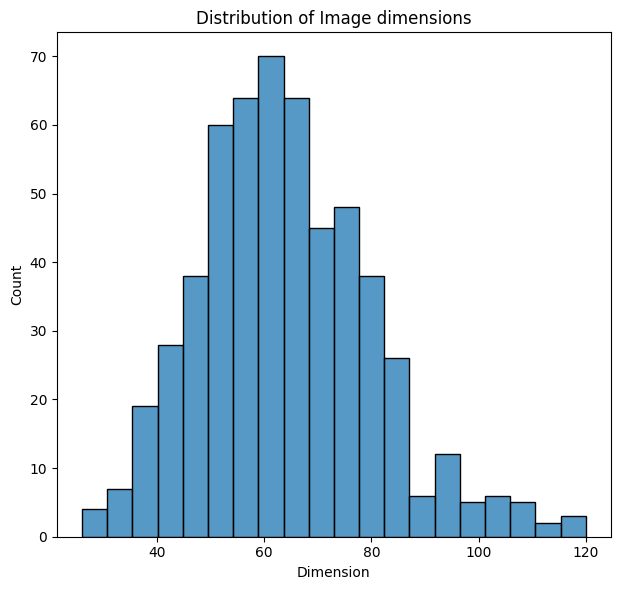

In [190]:
print(f"Smallest dimension: {min(image_sizes)}")

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(image_sizes)
plt.title('Distribution of Image dimensions')
plt.xlabel('Dimension')
plt.tight_layout()
plt.show()

As you can see from the graph, the images are not all the same size. This will cause issues when we try to train the model, so we need to resize all the images to the same size. Additionally one of the images is only 3x3 which is way too small to be useful, so we will remove that image.

In [191]:
# Iterate through all the images and resize to a fixed size
for subdir, dirs, images in os.walk(DATA_DIR):
    for image in images:
        file_path = os.path.join(subdir, image)
        with Image.open(file_path) as img:
            current_size = img.size
            if img.size[0] < 5:
                os.remove(file_path)
            
            target_size = 50
            
            resized_img = img.resize((target_size, target_size))
            resized_img.save(file_path)

# Data Augmentation

Now that all the images are the same size, we can begin with augmenting the images. This will involve randomly flipping rotating the images to create more data for the model to train on and prevent overfitting.
Note, there are many more augmentation techniques that can be used such as scaling, randomly cropping, randomly erasing, distorting, and blurring, but for now we will only use rotation and flipping.

In [192]:
# How many augmented images should be generated as a percentage of the current
percent_augmented = 0.5 # 0 to 1
augments = [(0, 90), (0, 180), (0, 270), (1, 0), (1, 90), (1, 180), (1, 270)]

train_dir = os.path.join(DATA_DIR, 'train')

# Iterate through all the images and resize to a fixed size
for subdir, dirs, images in os.walk(train_dir):
    for image in images:
        file_path = os.path.join(subdir, image)
        with Image.open(file_path) as img:
            if random.random() <= percent_augmented:
                augmented_img = img

                augment = random.choice(augments)

                if augment[0]:
                    augmented_img = augmented_img.transpose(Image.FLIP_LEFT_RIGHT)
                if augment[1]:
                    augmented_img = augmented_img.rotate(augment[1])

                name, extension = image.rsplit('.', 1)
                save_file_path = os.path.join(subdir, f"{name}.aug.{extension}")

                augmented_img.save(save_file_path)

In [103]:
import glob

png_files = glob.glob(f"{DATA_DIR}/**/*.png", recursive=True)
aug_png_files = glob.glob(f"{DATA_DIR}/**/*.aug.png", recursive=True)

print(f"Number of .png files in the data directory: {len(png_files)}")
print(f"Number of .aug.png files in the data directory: {len(aug_png_files)}")

Number of .png files in the data directory: 762
Number of .aug.png files in the data directory: 212


# Feature Extraction

In [22]:
import torch
import torchvision.models as models

import torchvision.transforms.v2 as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [23]:
# Load pre-trained ResNet
resnet = models.resnet50(pretrained=True)

# Remove the last fully connected layer for feature extraction
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))

# Set model to evaluation mode
resnet.eval()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/home/miikey_lol/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/miikey_lol/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/miikey_lol/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [24]:
# Load images with augmentation
dataset = ImageFolder(root=DATA_DIR, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

features = []
labels = []

for i, (inputs, label_batch) in enumerate(data_loader):
    # Move inputs to the appropriate device (GPU if available)
    inputs = inputs.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    # Forward pass, get the features
    with torch.no_grad():
        output = resnet(inputs)

    # Convert output to the desired format and store
    feature_batch = output.cpu().detach().numpy().flatten().reshape(-1, 2048) # Adjust shape based on the model
    features.extend(feature_batch)

    # Store labels
    labels.extend(label_batch.numpy())
    
    # Print progress
    print(f"Processed batch {i+1}/{len(data_loader)}")

# `features` now contains the extracted features for each image

# Convert the features list to a pandas DataFrame
df_features = pd.DataFrame(features)
df_features['label'] = labels

# Get the mapping of class indices to class names
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

# Map the numeric labels to class names
df_features['character'] = df_features['label'].map(idx_to_class)

# Define the output file path
output_file = 'features.xlsx'

# Save the DataFrame to Excel
df_features.to_excel(output_file, index=False)


Processed batch 1/35
Processed batch 2/35
Processed batch 3/35
Processed batch 4/35
Processed batch 5/35
Processed batch 6/35
Processed batch 7/35
Processed batch 8/35
Processed batch 9/35
Processed batch 10/35
Processed batch 11/35
Processed batch 12/35
Processed batch 13/35
Processed batch 14/35
Processed batch 15/35
Processed batch 16/35
Processed batch 17/35
Processed batch 18/35
Processed batch 19/35
Processed batch 20/35
Processed batch 21/35
Processed batch 22/35
Processed batch 23/35
Processed batch 24/35
Processed batch 25/35
Processed batch 26/35
Processed batch 27/35
Processed batch 28/35
Processed batch 29/35
Processed batch 30/35
Processed batch 31/35
Processed batch 32/35
Processed batch 33/35
Processed batch 34/35
Processed batch 35/35


In [25]:
df_features[:84*32].to_excel(output_file)

In [26]:
# Convert DataFrame to NumPy array
array = df_features.values

# Save as .npy file
np.save('df_features.npy', array)